In [2]:
import numpy as np
import matplotlib.pyplot as plt

import layers
from data_utils import load_CIFAR10

In [3]:
# def affine_forward(x, W, b): 
#     """
#     A linear mapping from inputs to scores.
#     Inputs:
#         - x: input matrix (N, d1, d2, ...dn)
#         - N: weigh matrix (D, C)
#         - b: bias vector (C, )
#     Outputs:
#         - out: output of linear layer (N, C)
#     """
#     x2d = np.reshape(x, (x.shape[0], -1)) # convert 4D input matrix to 2D
#     out = np.dot(x2d, W) + b # Linear transformation
#     cache = (x, w, b) # keep fbr backward step (stay with us)
#     return out, cache   

In [4]:
# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'spline16'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [5]:
np.set_printoptions(formatter={'all': lambda x: "%.2f" % x}) #ماتریس تا دو رقم اعشار

In [6]:
from data_utils import load_CIFAR10

# Load the raw CIFAR-10 data.
cifar10_dir = 'ds/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
#بعد از خواندن داده ها ۴ تا ماتریس به ما میدهد
# As a sanity check, we print out the size of the training and test data.
print('Training data shape:   ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape:       ', X_test.shape)
print('Test labels shape:     ', y_test.shape)

Training data shape:    (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:        (10000, 32, 32, 3)
Test labels shape:      (10000,)


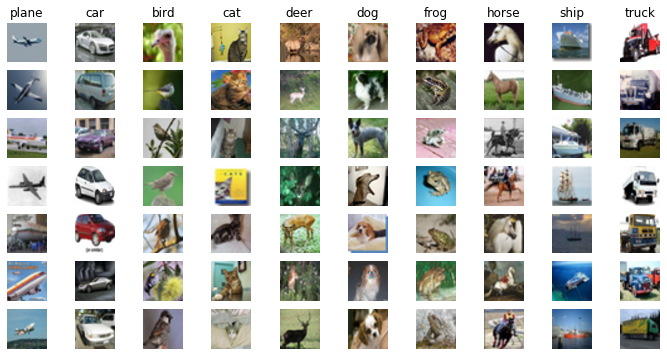

In [7]:
#نمایش تصادفی تعدادی از تصاویر 
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [8]:
# مرحله پیش پردازش
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape:        ', X_train.shape)
print('Train labels shape:      ', y_train.shape)
print('Validation data shape:   ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape:         ', X_test.shape)
print('Test labels shape:       ', y_test.shape)

Train data shape:         (49000, 32, 32, 3)
Train labels shape:       (49000,)
Validation data shape:    (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:          (1000, 32, 32, 3)
Test labels shape:        (1000,)


In [9]:
# ماتریس ها را تغییر شکل میدهیم، دوبعدی میکنیم
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape:   ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape:       ', X_test.shape)
print('dev data shape:        ', X_dev.shape)

Training data shape:    (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:        (1000, 3072)
dev data shape:         (500, 3072)


[130.64 135.98 132.47 130.06 135.35 131.75 130.96 136.14 132.48 131.48]


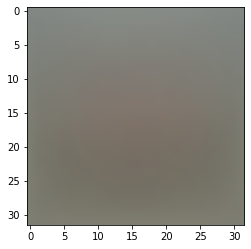

In [10]:
# میانگین تصاویر را محاسبه میکنیم
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()


In [11]:
# میانگین را از همه تصاویر کم میکنیم
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val   -= mean_image
X_test  -= mean_image
X_dev   -= mean_image

In [21]:
# loss function تابع هزینه
def L_i(x,y,W):
    """
    unvectorized version. Compute the multiclass svm loss for a single example (x,y)
    - x is a column vector representing an image (e.g. 3073 x 1 in CIFAR-10)
      with an appended bias dimension in the 3073-rd position (i.e. bias trick)
    - y is an integer giving index of correct class (e.g. between 0 and 9 in CIFAR-10)
    - W is the weight matrix (e.g. 10 x 3073 in CIFAR-10)
    """
    
#     scores: (49000, 10)
#     y_train: (49000,)
#     W: (3072, 10)
    # محاسبه امتیازها
    scores = W.dot(x) # scores becomes of size 10 x 1, the scores for each class
    # امتیاز کلاس درست
    correct_class_score = scores[y]
    C = W.shape[0] # number of classes, e.g. 10
    
    loss_i = 0.0
    for j in range(C): # iterate over all wrong classes
        if j == y:
            # skip for the true class to only loop over incorrect classes
            continue
        # accumulate loss for the i-th example
        loss_i += max(0, scores[j] - correct_class_score + 1.0)
    return loss_i
    # در نهایت لاس داده آی ام محاسبه و به خروجی ارسال میشود

In [13]:
# شکل دیگر پیاده سازی تابع لاس
# نیمه برداری
def L_i_vectorized(x, y, W):
    """
    A faster half-vectorized implementation. 
    Half-vectorized refers to the fact that for a single example the implementation contains
    no for loops, but there is still one loop over the examples (outside this function)
    """
    scores = W.dot(x)
    margins = np.maximum(0, scores - scores[y] + 1.0)
    margins[y] = 0  # cancel the correct class loss
    loss_i = np.sum(margins)
    return loss_i

In [42]:
# create W and b randomly with small numbers
N = X_train.shape[0]           # number of training data
D = np.prod(X_train.shape[1:]) # number of features
C = 10                         # number of classes

print("N:",N)
print("D:",D.shape)
print(C)
# ماتریس وزن تصادفی ایجاد میکنیم و بی
# init parameters
W = 0.0001 * np.random.randn(D, C)
b = np.zeros((C,))

N: 49000
D: ()
10


In [15]:
from layers import affine_forward, svm_loss_naive

In [16]:
scores, _ = affine_forward(X_train, W, b)
loss, _ = svm_loss_naive(scores, y_train, W, reg=0.0)

print("Data loss = %.2f" % loss)

Data loss = 9.15


In [17]:
print("scores = ", scores[0])
print("correct class score = %.2f" % scores[0][y_train[0]])

scores =  [0.34 0.13 -0.03 0.66 -0.38 -0.21 0.11 0.04 0.18 0.00]
correct class score = 0.11


In [18]:
i = 0  # first training data
margins = scores[i] - scores[i][y_train[i]] + 1.0
margins[y_train[i]] = 0.0

print(margins)
print(np.sum(np.maximum(0.0, margins)))

[1.23 1.02 0.86 1.55 0.51 0.68 0.00 0.93 1.07 0.89]
8.724200039399701


In [39]:
# مقایسه زمانهای اجرا دو نوع تابع لاس
import time

# time of naive implementation (two-loop version)
# tic = time.time()
# loss_naive = L_i(scores, y_train, W)
# toc = time.time()
# naive_time = toc - tic
# print('Naive loss: \t %.5f computed in %fs' % (loss_naive, naive_time))
# print("scores:",scores.shape)
# print("y_train:",y_train.shape)
# print("W:",W.shape)
# scor = W.dot(scores)
# print(scor)

# time of fully vectorized implementation (no-loop version)
# tic = time.time()
# loss_vectorized = L_i_vectorized(scores, y_train, W)
# toc = time.time()
# vec_time = toc - tic
# print('Vectorized loss: %.5f computed in %fs' % (loss_vectorized, vec_time))

# The losses should match but your vectorized implementation should be much faster.
# print('difference: \t %f' % (loss_naive - loss_vectorized))
# print('ratio: \t\t %f' % (naive_time / vec_time))

Naive loss: 	 9.15090 computed in 0.458915s
scores: (49000, 10)
y_train: (49000,)
W: (3072, 10)


ValueError: shapes (3072,10) and (49000,10) not aligned: 10 (dim 1) != 49000 (dim 0)

In [ ]:
from layers import affine_forward, svm_loss_naive